In [1]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [2]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 400
 # 115, 150

In [3]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [4]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [5]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [6]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [7]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [8]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [9]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [10]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [11]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [12]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [13]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [14]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])
                
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [15]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [16]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [17]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [18]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [19]:
def main():
    r = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,1000),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:
        a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
        print(f"Tempo: {t}")
        D = np.linalg.norm(Uto-Uf)**2
        distance_vector.append(D)
        fx_vector.append(a)
        fy_vector.append(b)
        fz_vector.append(c)
        rt = np.dot(Uto, r0)
        pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
        if isinstance(t, float):
             rho_vector[0][int(round(t,0))+r] = pt[0][0]
             rho_vector[1][int(round(t,0))+r] = pt[0][1]
             rho_vector[2][int(round(t,0))+r] = pt[1][0]
             rho_vector[3][int(round(t,0))+r] = pt[1][1]
             r += 1
        else:
            rho_vector[0][t] = pt[0][0]
            rho_vector[1][t] = pt[0][1]
            rho_vector[2][t] = pt[1][0]
            rho_vector[3][t] = pt[1][1]
        fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
        fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
        while 1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1:
            print(f"Processo de infactibilidade")
            print(f"Porta: {fid_autores[-1]}")
            print(f"Estados: {fid_vector[-1]}")
            print(f"Distância: {D}")
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            fid_vector[-1] = ((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores[-1] = ((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            aas[-1] = ((u[0],u[1],u[2]))
            D = np.linalg.norm(Uto-Uf)**2
        
        if t <= 70:
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
        elif t > 70:
            h = 0.0001
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 0.1
        Ut = Uto

    print(f"O rho gerado foi: {pt}") 
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [20]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal
Tempo: 0
Tempo: 1
Tempo: 2
Tempo: 3
Tempo: 4
Tempo: 5
Tempo: 6
Tempo: 7
Tempo: 8
Tempo: 9
Tempo: 10
Tempo: 11
Tempo: 12
Tempo: 13
Tempo: 14
Tempo: 15
Tempo: 16
Tempo: 17
Tempo: 18
Tempo: 19
Tempo: 20
Tempo: 21
Tempo: 22
Tempo: 23
Tempo: 24
Processo de infactibilidade
Porta: 1.0042984741874073
Estados: (1.0017991693347306+1.8704528405332686e-05j)
Distância: 0.007708406243557481
Tempo: 25
Tempo: 26
Tempo: 27
Tempo: 28
Tempo: 29
Tempo: 30
Tempo: 31
Tempo: 32
Tempo: 33
Tempo: 34
Tempo: 35
Tempo: 36
Tempo: 37
Processo de infactibilidade
Porta: 1.0000777806923289
Estados: (0.9994950395457927-4.3132736331911595e-05j)
Distância: 0.012793184361155627
Tempo: 38
Tempo: 39
Tempo: 40
Processo de infactibilidade
Porta: 1.0019541915721135
Estados: (1.0003291957696636+1.5288618394998142e-05j)
Distância: 0.00514726817139972
Tempo: 41
Tempo: 42
Tempo: 43
Tempo: 44
Processo de infactibilidade
Porta: 1.0020470175390281
Estados: (1.0003848234199961-2.6430562363696788e-05j)
Distâ

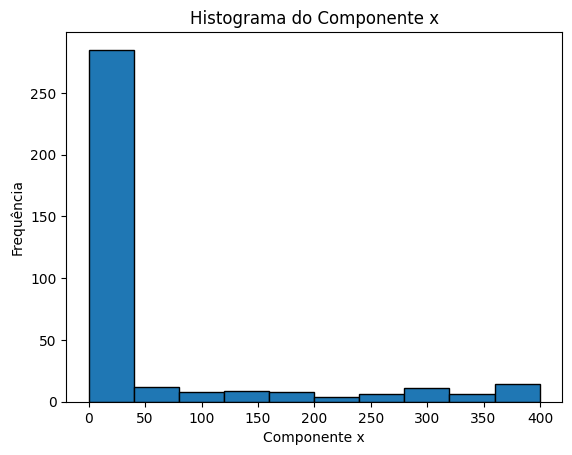

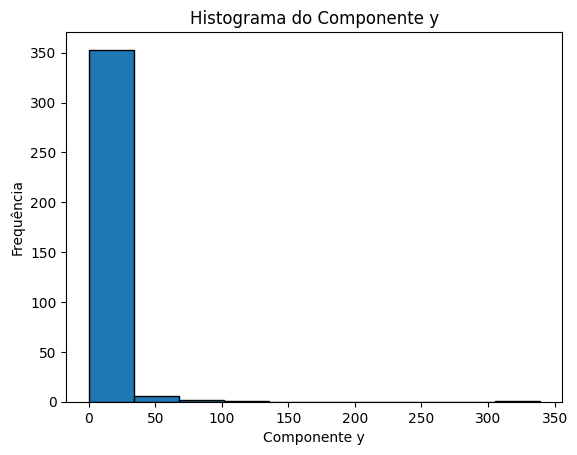

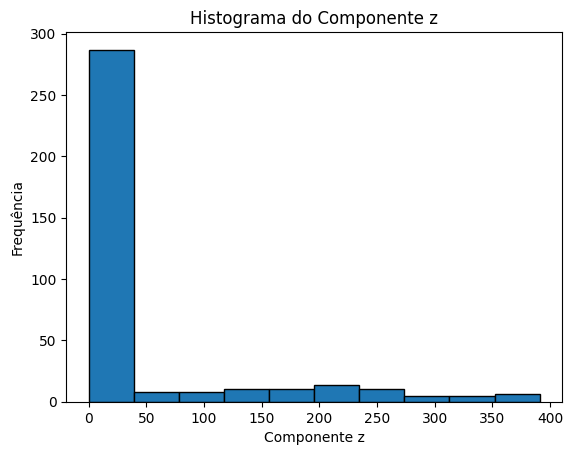

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9999642122428917
Estados: (0.9995550240023737-3.3001905742220144e-10j)
Distância: 0.00667388713937975
 


In [21]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [22]:
fid_vector

[np.clongdouble('0.50014465186685759925+0j'),
 np.clongdouble('0.49960589195139742307+6.8331973362950896584e-05j'),
 np.clongdouble('0.49963710499083004046-0.00015233637754298567246j'),
 np.clongdouble('0.49970518750368557578-0.00014966515042069437689j'),
 np.clongdouble('0.36180793697643410376-6.6041040802017111916e-05j'),
 np.clongdouble('0.51031908420710661676-0.00012434675061135190182j'),
 np.clongdouble('0.65710894238902284754-6.840872847199669129e-05j'),
 np.clongdouble('0.6572239601679640853-9.000505959311384338e-17j'),
 np.clongdouble('0.81773821021959913833+0.00021017629983513686903j'),
 np.clongdouble('0.8179579234436612525+8.262365395459915302e-05j'),
 np.clongdouble('0.8179466207658299282-8.4972460396323345376e-05j'),
 np.clongdouble('0.82754230735152043796-0.00021196610473513569797j'),
 np.clongdouble('0.87263466078254024163+0.00022053512189781723854j'),
 np.clongdouble('0.95047042512692995244-4.0998708073751587526e-05j'),
 np.clongdouble('0.95036531834845716703-6.28190468

In [23]:
fid_autores

[np.float64(0.332466605362096),
 np.float64(0.3151604861510273),
 np.float64(0.2833527428087413),
 np.float64(0.2833443830564342),
 np.float64(0.27308143796355605),
 np.float64(0.2500226681467365),
 np.float64(0.2742505526113497),
 np.float64(0.3376777835163953),
 np.float64(0.47453527493709585),
 np.float64(0.6019518580730693),
 np.float64(0.6729892358815687),
 np.float64(0.6911457665207212),
 np.float64(0.7616679523745212),
 np.float64(0.8941518709014583),
 np.float64(0.9033065052477461),
 np.float64(0.9721044531997484),
 np.float64(0.9753324452982163),
 np.float64(0.9753099311252171),
 np.float64(0.9899416043716677),
 np.float64(0.9902725340791342),
 np.float64(0.992274076787063),
 np.float64(0.994486771559011),
 np.float64(0.9954102629511103),
 np.float64(0.9954090117325608),
 np.float64(0.9953825461100445),
 np.float64(0.998695231209343),
 np.float64(0.9990842365968442),
 np.float64(0.9990576180652138),
 np.float64(0.999054463271786),
 np.float64(0.9990761346822526),
 np.float64(0

In [24]:
rho_vector

array([[0.5       +0.j        , 0.49956931+0.j        ,
        0.49958863+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.499995  +0.j        , 0.46352242-0.18747891j,
        0.35393975-0.35314177j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.499995  +0.j        , 0.46352242+0.18747891j,
        0.35393975+0.35314177j, ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.5       +0.j        , 0.50043069+0.j        ,
        0.50041137+0.j        , ..., 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ]])

In [25]:
distance_vector

[np.float64(7.989572496790412),
 np.float64(7.7685402580484135),
 np.float64(7.265429667588339),
 np.float64(7.265317557783705),
 np.float64(7.053049604273727),
 np.float64(6.062331375594515),
 np.float64(4.91849439481288),
 np.float64(3.946347505463952),
 np.float64(2.714974726998863),
 np.float64(1.8876573179201144),
 np.float64(1.4934744437857082),
 np.float64(1.3977140448708785),
 np.float64(1.0434599369842843),
 np.float64(0.4409293766484674),
 np.float64(0.404140165390463),
 np.float64(0.12646048967892348),
 np.float64(0.11463499110152835),
 np.float64(0.11461906216080432),
 np.float64(0.05539722400629471),
 np.float64(0.053973387438218716),
 np.float64(0.04581087923827178),
 np.float64(0.036808159787043944),
 np.float64(0.032992905348755125),
 np.float64(0.03289075269488511),
 np.float64(0.007708406243557481),
 np.float64(0.01950406226316896),
 np.float64(0.01783892196663591),
 np.float64(0.017838425266273758),
 np.float64(0.017743971047967447),
 np.float64(0.01759250144836132),

In [26]:
fx_vector

[np.float64(101.66865587199521),
 np.float64(-0.01588352924255435),
 np.float64(-0.009165622535255703),
 np.float64(-0.009129045822470821),
 np.float64(-0.006230781397791923),
 400,
 400,
 np.float64(-0.0007768246130665876),
 400,
 np.float64(0.0006716398394789414),
 np.float64(0.0009548686275260202),
 np.float64(0.0009595205332103909),
 np.float64(115.07357124518518),
 np.float64(204.92411870898547),
 np.float64(0.0010070501453149432),
 np.float64(42.75208097914109),
 np.float64(11.720190223090098),
 np.float64(0.004343503210805948),
 np.float64(0.0014810149074071367),
 np.float64(9.856427404767738),
 np.float64(0.0030201970505806574),
 np.float64(0.0021051120944274794),
 np.float64(0.0020275613816836246),
 np.float64(1.93860576842604),
 np.float64(-0.002797281774794032),
 np.float64(0.000803143009060364),
 np.float64(0.0007394163550982069),
 np.float64(0.0007489716555039284),
 np.float64(2.0457572623638662),
 np.float64(-0.9081117844466097),
 np.float64(0.3715781481403225),
 np.float

In [27]:
fy_vector

[np.float64(0.0),
 np.float64(-0.1060630317312446),
 np.float64(-0.021993611756786477),
 np.float64(0.08326128995997628),
 400,
 np.float64(-0.025595057747825865),
 np.float64(-0.020127913167085464),
 np.float64(-0.0031626136958107483),
 np.float64(0.0008121357856682684),
 np.float64(0.002511347857581183),
 np.float64(0.0020750469250127466),
 np.float64(79.10835266117135),
 np.float64(0.0027208335542191204),
 np.float64(0.0016688835320566844),
 np.float64(0.0014531486934382157),
 np.float64(0.0004193977402367537),
 np.float64(0.0004510878263482356),
 np.float64(0.00047419725502085804),
 np.float64(63.53793693575749),
 np.float64(0.0003079323674284107),
 np.float64(0.0002659839294465171),
 np.float64(16.654098100343294),
 np.float64(0.0002005937245620845),
 np.float64(0.0002006409704966481),
 np.float64(-30.85268886503043),
 np.float64(27.92775685370831),
 np.float64(8.960352200325436e-05),
 np.float64(9.076594312994448e-05),
 np.float64(9.054439482830089e-05),
 np.float64(8.77209117570

In [28]:
fz_vector

[np.float64(0.0),
 400,
 400,
 np.float64(-0.00877791427531935),
 np.float64(-0.011213102545624716),
 np.float64(-0.005082157711592295),
 np.float64(-0.0019208254076925743),
 400,
 np.float64(0.00011995582793771093),
 np.float64(334.2402109306589),
 np.float64(221.06398769795967),
 np.float64(0.006456674527987331),
 np.float64(0.005219342603935425),
 np.float64(0.0024579697593230367),
 np.float64(34.94054084659699),
 np.float64(0.001070787604175927),
 np.float64(0.0011300874979368466),
 np.float64(0.0357667592685257),
 np.float64(0.00048231780894018725),
 np.float64(0.0004859257481472767),
 np.float64(21.47164117874425),
 np.float64(0.00042282191274892823),
 np.float64(13.905118368784747),
 np.float64(0.0004956331415557632),
 np.float64(-0.0007689724667927587),
 np.float64(0.0001781590828612425),
 np.float64(8.014824551802635),
 np.float64(0.00019388282968905155),
 np.float64(0.00019288965808849447),
 np.float64(0.00018478067867298365),
 np.float64(0.00018941404494900556),
 np.float64(

In [29]:
a

[(np.float64(101.66865587199521), np.float64(0.0), np.float64(0.0)),
 (np.float64(6.150344482592746e-224),
  np.float64(0.0),
  np.float64(187.91060794047266)),
 (np.float64(0.0), np.float64(0.0), np.float64(224.2846755939005)),
 (np.float64(0.0), np.float64(0.025469080235799652), np.float64(0.0)),
 (np.float64(0.0), np.float64(338.74817826999833), np.float64(0.0)),
 (np.float64(299.184499123162), np.float64(0.0), np.float64(0.0)),
 (np.float64(233.94230824759396),
  np.float64(2.0046465595624983e-99),
  np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0), np.float64(299.85045965473216)),
 (np.float64(130.9764797242721),
  np.float64(0.0),
  np.float64(2.9371797912196727e-83)),
 (np.float64(0.0), np.float64(0.0), np.float64(93.37615337830422)),
 (np.float64(0.0), np.float64(0.0), np.float64(251.93930426660626)),
 (np.float64(6.763554283061876e-22),
  np.float64(54.12715757567796),
  np.float64(0.0)),
 (np.float64(29.394438578170945),
  np.float64(0.0),
  np.float64(4.866605583965511e-